## Imports

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

## Parameters

### Inputs

In [14]:
edges_inputs_df = pd.read_csv("../inputs/edges_input.csv")
edges_inputs_label = edges_inputs_df['label'].values

In [15]:
radnet_inputs_df = pd.read_csv("../inputs/radnet_input.csv")
radnet_inputs_label = radnet_inputs_df['label'].values

### Outputs

In [16]:
inference_output_df = pd.read_csv("../outputs/inference_output.csv")
inference_output_class = inference_output_df['class'].values
inference_output_confidence = inference_output_df['confidence'].values

In [17]:
fusion_output_df = pd.read_csv("../outputs/fusion_output.csv")
fusion_output_class = fusion_output_df['class'].values
fusion_output_confidence = fusion_output_df['confidence'].values

In [18]:
kalman_output_df = pd.read_csv("../outputs/kalman_output.csv")
kalman_output_class = kalman_output_df['class'].values
kalman_output_confidence = kalman_output_df['confidence'].values

## Confiança

### Confiança x Arestas

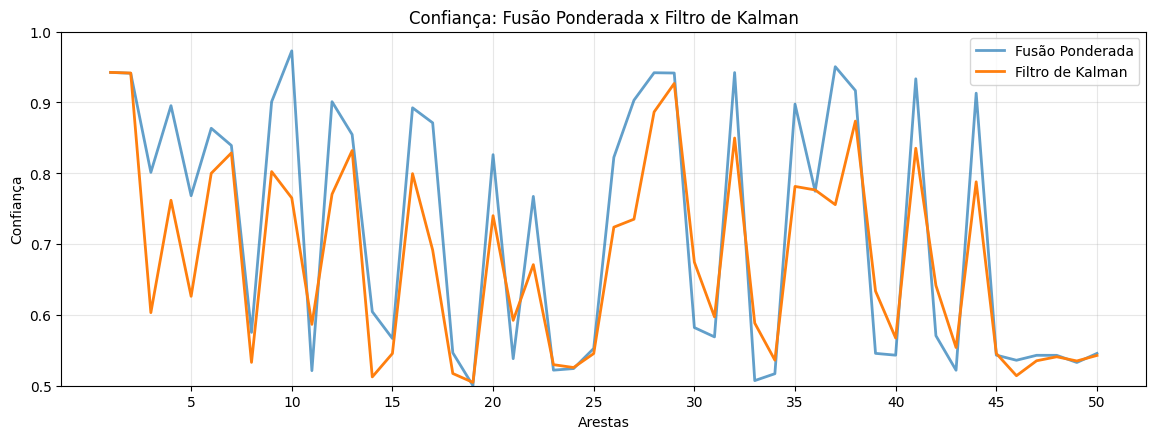

In [19]:
x = np.arange(1, len(fusion_output_confidence)+1)

plt.figure(figsize=(14, 4.6))

plt.plot(x, fusion_output_confidence, label="Fusão Ponderada", alpha=0.7, linewidth=2)
plt.plot(x, kalman_output_confidence, label="Filtro de Kalman", linewidth=2)

plt.title("Confiança: Fusão Ponderada x Filtro de Kalman")
plt.xlabel("Arestas")
plt.ylabel("Confiança")

N = len(fusion_output_confidence)
xticks = list(np.arange(5, N+1, 5))
if N not in xticks:
    xticks.append(N)
plt.xticks(xticks)

plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 1)

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/confidence_fusion_kalman.png', dpi=300, bbox_inches='tight')
plt.show()

### Classificação x Arestas

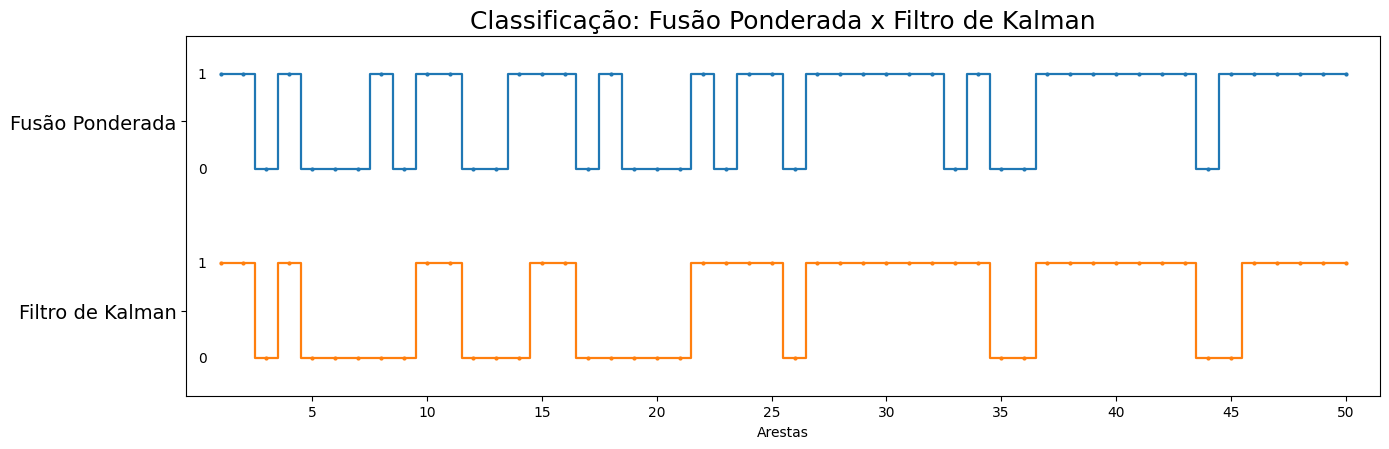

In [20]:
fus = np.asarray(fusion_output_class).astype(int)
kal = np.asarray(kalman_output_class).astype(int)
N = min(len(fus), len(kal))
fus, kal = fus[:N], kal[:N]

x = np.arange(1, N+1)

colors = {"Fusion":"tab:blue", "Kalman":"tab:orange"}

plt.figure(figsize=(14, 4.6))
ax = plt.gca()

rows = [
    ("Kalman", kal, 0.0),
    ("Fusion",  fus, 2.0),
]

for lab, yvals, yoff in rows:
    ax.plot(
        x, yoff + yvals,
        drawstyle="steps-mid",
        linewidth=1.6,
        marker="o", markersize=2,
        color=colors[lab], label=lab
    )

ax.set_yticks([0.5, 2.5])
ax.set_yticklabels(["Filtro de Kalman", "Fusão Ponderada"], fontsize=14)

ax.set_xlabel("Arestas")
ax.set_title("Classificação: Fusão Ponderada x Filtro de Kalman", fontsize=18)

pad = 0.03 * N
ax.set_xlim(1 - pad, N + pad)
ax.set_ylim(-0.4, 3.4)

xticks = list(np.arange(5, N+1, 5))
if N not in xticks:
    xticks.append(N)
ax.set_xticks(xticks)

xlab = 1 - pad*0.4

for _, _, yoff in rows:
    ax.text(xlab, yoff + 0, "0", va="center", ha="right")
    ax.text(xlab, yoff + 1, "1", va="center", ha="right")

plt.tight_layout()

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/classification_fusion_kalman.png', dpi=300, bbox_inches='tight')
plt.show()

## Matriz de Confusão

In [21]:
w_model = 0.4
w_efsr = 0.6

### Matriz de Confusão: Fusão Podenrada SEM Filtro de Kalman

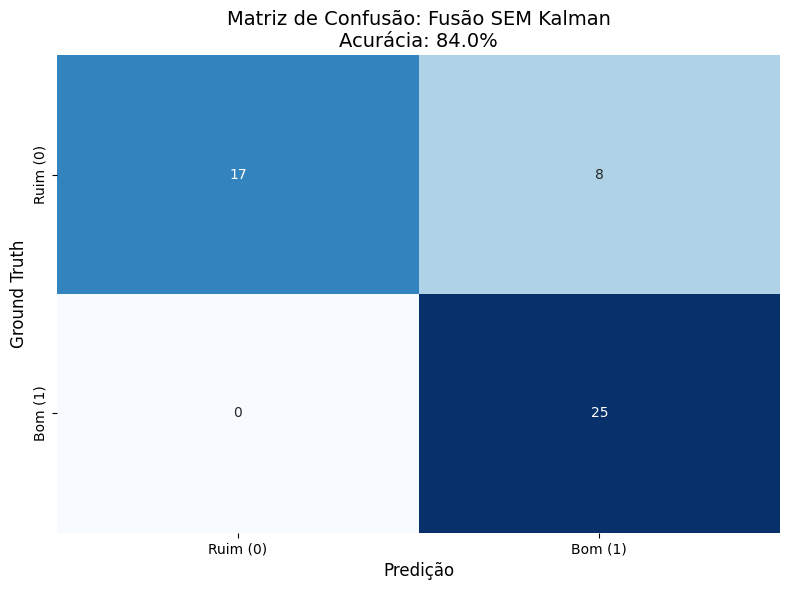

In [22]:
ground_truth = []
for i in range(len(edges_inputs_label)):
    score = (edges_inputs_label[i] * w_model) + (radnet_inputs_label[i] * w_efsr)
    if score >= 0.5:
        ground_truth.append(1)
    else:
        ground_truth.append(0)

acc = accuracy_score(ground_truth, fusion_output_class)
cm = confusion_matrix(ground_truth, fusion_output_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Ruim (0)', 'Bom (1)'], 
            yticklabels=['Ruim (0)', 'Bom (1)'])
plt.xlabel('Predição', fontsize=12)
plt.ylabel('Ground Truth', fontsize=12)
plt.title(f'Matriz de Confusão: Fusão SEM Kalman\nAcurácia: {acc*100:.1f}%', fontsize=14)
plt.tight_layout()

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/confusion_matrix_fusion_without_kalman.png', bbox_inches='tight')
plt.show()

### Matriz de Confusão: Fusão Podenrada COM Filtro de Kalman

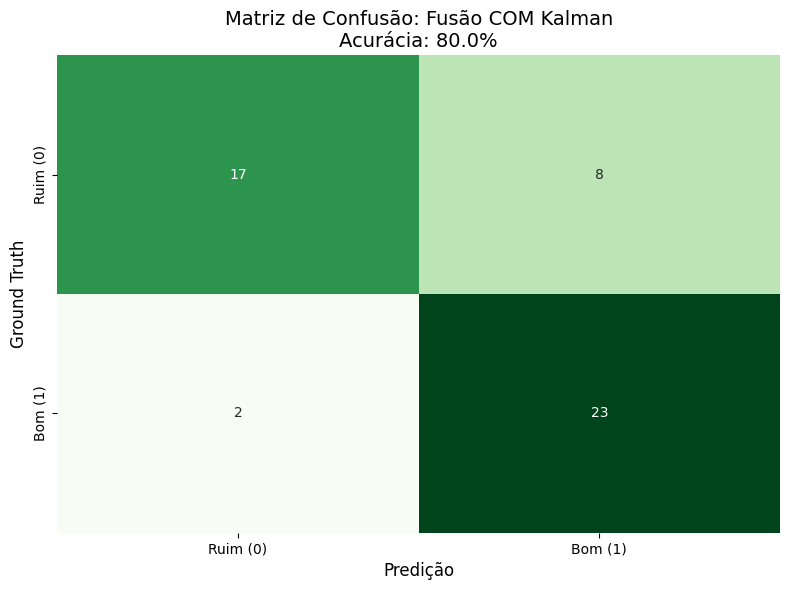

In [23]:
ground_truth = []
for i in range(len(edges_inputs_label)):
    score = (edges_inputs_label[i] * w_model) + (radnet_inputs_label[i] * w_efsr)
    if score >= 0.5:
        ground_truth.append(1)
    else:
        ground_truth.append(0)

acc = accuracy_score(ground_truth, kalman_output_class)
cm = confusion_matrix(ground_truth, kalman_output_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Ruim (0)', 'Bom (1)'], 
            yticklabels=['Ruim (0)', 'Bom (1)'])
plt.xlabel('Predição', fontsize=12)
plt.ylabel('Ground Truth', fontsize=12)
plt.title(f'Matriz de Confusão: Fusão COM Kalman\nAcurácia: {acc*100:.1f}%', fontsize=14)
plt.tight_layout()

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/confusion_matrix_fusion_with_kalman.png', bbox_inches='tight')
plt.show()